In [1]:
#descargamos de gdrive de la ayudante los archivos
#https://stackoverflow.com/questions/48735600/file-download-from-google-drive-to-colaboratory
!gdown --id 1F-n7ReLD0Oje_FBT3s2wlqxrKi8Qbpqg
!gdown --id 1Vw-wdt7dz7O3Hj23_xw3UK7IO5yRphEC
!gdown --id 10no_phQynbbbWYKmmxKd-Ll0ScQfRvaF
!gdown --id 1Vpz_WawemxR-m0eau5ujK5CFItZNRp-0

#ahora tenemos que dividir las imagenes descargadas en test y validacion, 
#pero antes, hacemos unzip
!unzip test_images.zip
!unzip train_val_images.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/neum_b_15.png    
  inflating: images/neum_v_467.png   
  inflating: images/anormal2_1204.png  
  inflating: images/neum_v_94.png    
  inflating: images/normal_989.png   
  inflating: images/covid2_29.png    
  inflating: images/covid1_238.png   
  inflating: images/neum_b_515.png   
  inflating: images/anormal2_1181.png  
  inflating: images/anormal2_914.png  
  inflating: images/covid2_97.png    
  inflating: images/anormal2_1040.png  
  inflating: images/normal_333.png   
  inflating: images/anormal2_424.png  
  inflating: images/neum_v_270.png   
  inflating: images/anormal2_730.png  
  inflating: images/normal_634.png   
  inflating: images/normal_1017.png  
  inflating: images/normal_444.png   
  inflating: images/covid2_163.png   
  inflating: images/anormal1_119.png  
  inflating: images/normal_623.png   
  inflating: images/neum_v_606.png   
  inflating: images/covid1_128.png   
  inflating: images/normal_

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pickle as pk
from skimage import io
import cv2
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Input,MaxPooling2D
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dropout
import torch
#torch.cuda.get_device_name(0)
#creditos a Rodrigo Richards, el me enseño a activar la gpu
#>Tools > Change Runtime Type > GPU

from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import f1_score

Shape de imagen es =  (256, 256)
3649
3649
1564
1564
Train Images [0] [[  0   4   9 ... 150 149 120]
 [  8  40  26 ... 204 204 163]
 [  0   0   0 ... 213 215 170]
 ...
 [  0   0   0 ... 124 107  75]
 [  0   0   0 ... 169 123  74]
 [  0   0   0 ... 134 134  81]]
Type de train images [0] <class 'numpy.ndarray'>
Type de train images <class 'list'>
Type de train label [0] <class 'int'>
Type de train label <class 'list'>
Train covid:  896
Train no covid:  2753


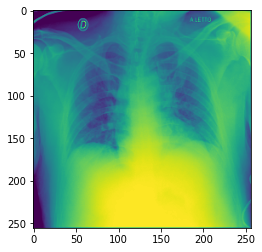

In [3]:
#data_split nos va a indicar como separaremos train y val data
with open('train_val_files.pkl', 'rb') as pickleFile:
  dataSplit = pk.load(pickleFile)

#print(dataSplit)

trainImages = []
trainLabels = []
valImages = []
valLabels = []
numCovid = 0
numNoCovid = 0

#cargamos los datos de training y de validacion y les damos sus labels
#correspondientes
#creditos a Rodrigo Estay, el me ayudo en esta parte
for fileName in dataSplit["train"]:
  if fileName.find("covid") != -1:
    #print("-", end='')
    trainLabels.append(1)
    numCovid = numCovid + 1
  else:
    #print("|", end='')
    numNoCovid = numNoCovid + 1
    trainLabels.append(0)
  auxImage = io.imread("images/" + fileName)
  trainImages.append(auxImage)

print("Shape de imagen es = ", trainImages[0].shape)

#y lo mismo para los datos de validacion
for fileName in dataSplit["validation"]:
  if fileName.find("covid") != -1:
    #print("-", end='')
    valLabels.append(1)
  else:
    #print("|", end='')
    valLabels.append(0)
  auxImage = io.imread("images/" + fileName)
  valImages.append(auxImage)
#https://appdividend.com/2020/12/02/python-join-list/

print(len(trainImages))
print(len(trainLabels))
print(len(valImages))
print(len(valLabels))

print("Train Images [0]", trainImages[0])
print("Type de train images [0]", type(trainImages[0]))
print("Type de train images" , type(trainImages))
print("Type de train label [0]", type(trainLabels[0]))
print("Type de train label" , type(trainLabels))
#trainImages[0] = np.fliplr(trainImages[0])
plt.imshow(trainImages[0])

print("Train covid: ", numCovid)
print("Train no covid: ", numNoCovid)


7298
7298
1564
1564
1
1


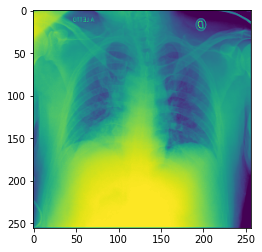

In [4]:
#AUMENTACION DE DATASET

#aumentemos el dataset haciendo un flip a los datos de training

#decidi usar solo un flip por miedo a que las rotaciones confundieran o alteraran
#el modelo, sin embargo, he visto proyectos similares donde se usan rotaciones
#leves, como -15,15 grados, donde eso ayuda al modelo a generalizar

#tambien algunos usan traslaciones de 0-35 pixeles

#sin embargo, opte por los flip porque me parecian sencillos, sin embargo, me
#pregunto si esto estara confundiendo al algoritmo un poco, debido a que el
#corazon usualmente esta desplazado hacia un lado, y tampoco se si hay mas
#asimetrias en el cuerpo humano, no tengo tanto conocimiento in depth de eso :(
    
#otra posibilidad era agregar ruido o blur a las imagenes, pero ya estaba 
#demorandose bastante el modelo, y estaba obteniendo resultados bastante buenos
#asique lo deje asi
trainImagesLength = len(trainImages)


for i in range(trainImagesLength):
  auxImage = np.fliplr(trainImages[i])
  trainImages.append(auxImage)
  trainLabels.append(trainLabels[i])

plt.imshow(trainImages[trainImagesLength])

print(len(trainImages))
print(len(trainLabels))
print(len(valImages))
print(len(valLabels))
print(trainLabels[0])
print(trainLabels[trainImagesLength])


In [5]:
#Convertimos trainImages y valImages a ndarray, esto para poder usarlos despues
#ya que algunas funciones requieren que sean npdarray y no listas de python
trainImages =  np.asarray(trainImages)
valImages =  np.asarray(valImages)


#Y ahora que son ndarrays los normalizamos y expandemos la dim para que calze en
#la red
trainImages = trainImages.astype("float32") / 255
valImages = valImages.astype("float32") / 255
trainImages = np.expand_dims(trainImages, -1)
valImages = np.expand_dims(valImages, -1)

print(type(trainImages[0]))
print(type(trainImages))
print(type(valImages))
print(type(trainLabels))
print(type(valLabels))
print(trainImages[0])

print(len(trainImages))
print(len(valImages))

print("Shape de imagen es = ", trainImages[0].shape)
#las imagenes ya estan en B&W, asique no hace falta pasarlas a B&W

#pero estos 2 son lists, y necesitamos nparray
#trainLabels
#valLabels
trainLabels = np.array(trainLabels)
valLabels = np.array(valLabels)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'list'>
[[[0.        ]
  [0.01568628]
  [0.03529412]
  ...
  [0.5882353 ]
  [0.58431375]
  [0.47058824]]

 [[0.03137255]
  [0.15686275]
  [0.10196079]
  ...
  [0.8       ]
  [0.8       ]
  [0.6392157 ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.8352941 ]
  [0.84313726]
  [0.6666667 ]]

 ...

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.4862745 ]
  [0.41960785]
  [0.29411766]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.6627451 ]
  [0.48235294]
  [0.2901961 ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.5254902 ]
  [0.5254902 ]
  [0.31764707]]]
7298
1564
Shape de imagen es =  (256, 256, 1)


In [6]:
#con los datos ya limpios, podemos hacer el modelo

#para llegar a este modelo fui probando con distintas cantidades de capas 
#convolucionales haciendo prueba y error

#primero tome como base el modelo que nos mostro la Ale en la practica 6

#primero empece con (C = convolucional, D = dense) 
#C64(dropout40%)
#MP
#C64(dropout40%)
#MP 
#D16(dropout40%) 
#D1
#estuve entrenando y probando bastante tiempo con esta red, use optimizadores
#distintos, SGD por ejemplo, pero en las primeras epocas no lograba mucho avance
#y despues se quedaba atascado, fluctuando mucho con los valores de loss y val_loss.
#La precision tambien era muy baja (76-80%)

#Al cambiar a adam obtuve mejroes resultados, asique me quede con ese

#Me di cuenta que la red no estaba haciendo un buen trabajo aun, puesto que nunca
#se intersectaba la loss con la val loss, pero predecia mejor que antes

#Agregue mas capas, C64 -> C64 -> C64 -> C64 -> D16 (con dropout) y mejoro la 
#prediccion, estaba obteniendo valores altos, de 90% accuracy o mas, pero aun 
#funcionaba mal y el problema del val loss y la loss seguia ahi

#Finalmente, estuve leyendo en varios lugares, y cuando lei aca
#https://www.pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/
#me di cuenta que quiza estaba regularizando mucho, asique reduje el dropout a
#25% y tambien aumente la ultima capa a D64 y los resultados han sido mejores 
#desde entonces asique lo deje asi

#Luego de hacer varias pruebas con ese modelo, me senti satisfecho
#ademas, se me acabo el tiempo de uso de GPU, asique seria dificil probar
#con otro modelo, cabe decir que este modelo se demora MUCHO en ejecutar sin
#aceleracion de GPU

#tambien tome inspiracion de aqui
#https://github.com/as4401s/COVID-19-X_ray-image-classification/blob/master/DenseNet121.ipynb

simpleCNN = Sequential()
simpleCNN.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(256,256,1)))
simpleCNN.add(Dropout(0.25))
simpleCNN.add(MaxPooling2D(pool_size=(2, 2)))
#
simpleCNN.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
simpleCNN.add(Dropout(0.25))
simpleCNN.add(MaxPooling2D(pool_size=(2, 2)))
#
simpleCNN.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
simpleCNN.add(Dropout(0.25))
simpleCNN.add(MaxPooling2D(pool_size=(2, 2)))
#
simpleCNN.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
simpleCNN.add(Dropout(0.25))
simpleCNN.add(MaxPooling2D(pool_size=(2, 2)))
#
simpleCNN.add(Flatten())
simpleCNN.add(layers.Dense(64, activation='relu'))
simpleCNN.add(Dropout(0.35))
simpleCNN.add(layers.Dense(1, activation='sigmoid'))

In [7]:
simpleCNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      640       
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 254, 254, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 125, 125, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        3

In [8]:
early_s_p = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.010, patience = 10, restore_best_weights=True)
#definimos un modelo con early stopping con paciencia y un min delta
#https://stackoverflow.com/questions/48285129/saving-best-model-in-keras/48924351

#bestWeights = ModelCheckpoint('simpleCNNweight.h5', monitor='val_loss', save_best_only=True)

In [9]:
#Este es el opt que use al principio, no fue adecuado
#opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

#usamos binary_crossentropy proque estamos clasificando un caso de 0 o 1
simpleCNN.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


In [10]:
history = simpleCNN.fit(trainImages, trainLabels, epochs=100, validation_data=(valImages, valLabels), callbacks = [early_s_p])

Epoch 1/100
229/229 [==============================] - 76s 138ms/step - loss: 0.4499 - accuracy: 0.7753 - val_loss: 0.3501 - val_accuracy: 0.8229
Epoch 2/100
229/229 [==============================] - 30s 132ms/step - loss: 0.2973 - accuracy: 0.8624 - val_loss: 0.3007 - val_accuracy: 0.8708
Epoch 3/100
229/229 [==============================] - 30s 132ms/step - loss: 0.2475 - accuracy: 0.8931 - val_loss: 0.2975 - val_accuracy: 0.8830
Epoch 4/100
229/229 [==============================] - 30s 131ms/step - loss: 0.2050 - accuracy: 0.9102 - val_loss: 0.2931 - val_accuracy: 0.8983
Epoch 5/100
229/229 [==============================] - 30s 131ms/step - loss: 0.1810 - accuracy: 0.9243 - val_loss: 0.2424 - val_accuracy: 0.9041
Epoch 6/100
229/229 [==============================] - 30s 131ms/step - loss: 0.1733 - accuracy: 0.9298 - val_loss: 0.2141 - val_accuracy: 0.9175
Epoch 7/100
229/229 [==============================] - 30s 131ms/step - loss: 0.1496 - accuracy: 0.9443 - val_loss: 0.2269 -

In [11]:
# Para guardar un modelo, deberia guardarse en los archivos
simpleCNN.save_weights('simpleCNN.h5')

In [12]:
#cargo los pesos
#simpleCNN.load_weights('simpleCNN.h5')

In [13]:
res_loss, res_acc = simpleCNN.evaluate(valImages, valLabels, verbose = 1)


print("Acc: ", res_acc)
print("Loss: ", res_loss)

49/49 [==============================] - 2s 34ms/step - loss: 0.1492 - accuracy: 0.9450
Acc:  0.9450128078460693
Loss:  0.14915680885314941


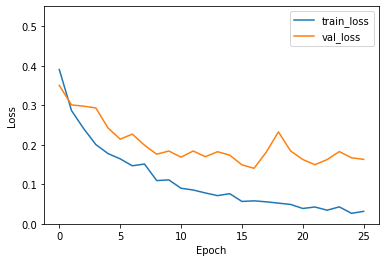

In [14]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 0.55])
plt.legend(loc='upper right')

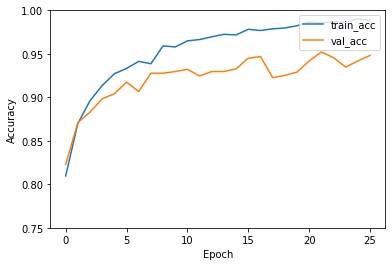

In [15]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.75, 1])
plt.legend(loc='upper right')

[0.90876675]
TP:  341
FP:  43
TN:  1137
FN:  43
0.9450127877237852
0.8880208333333334
0.8880208333333334
Score F1:  0.8880208333333333
Score F1:  0.8880208333333333


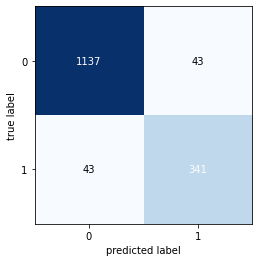

In [16]:
#calculemos la matriz con los TP, TN, FP, FN para ver que tal se desempeña la red
#hacemos el calculo de F1 con el validation
#true pos, true neg, false pos, false neg
TP = 0
TN = 0
FP = 0
FN = 0

P = simpleCNN.predict(valImages, steps=len(valImages))

print(P[5])

#vamos a tomar que +50% implica covid
#results va a guardar lo que hemos predecido
results = []

for i in range(len(P)):
  if (P[i] >= 0.5):
    #print(1)
    results.append(1)
  else:
    #print(0)
    results.append(0)

#reference guarda los valores reales, los de validation en este caso
reference = []

for i in range(len(valLabels)):
  if (valLabels[i] >= 0.5):
    #print(1)
    reference.append(1)
  else:
    #print(0)
    reference.append(0)

#for i in range(len(P)):
for i in range(len(P)):
  #print(results[i], " ", reference[i])
  if (results[i] == 1) and (reference[i] == 1):
    TP = TP + 1
  elif (results[i] == 1) and (reference[i] == 0):
    FP = FP + 1
  elif (results[i] == 0) and (reference[i] == 0):
    TN = TN + 1
  elif (results[i] == 0) and (reference[i] == 1):
    FN = FN + 1

print("TP: ", TP)
print("FP: ", FP)
print("TN: ", TN)
print("FN: ", FN)


#for i in range(len(P)):
#  print(P[i])


confMatrix = confusion_matrix (reference, results)
plot_confusion_matrix(confMatrix, figsize=(4,4))

#calcular F1
accuracy = 0
accuracy = (TN + TP)/(TN + FP + TP + FN)
print(accuracy)
precision = 0
precision = TP/(TP+FP)
print(precision)
recall = 0
recall = TP/(TP+FN)
print(recall)


scoreF1 = 0
scoreF1 = 2*(precision*recall)/(precision+recall)
print("Score F1: ", scoreF1)

bibF1 = f1_score(reference, results, zero_division=1)
print("Score F1: ",bibF1)

#https://www.youtube.com/watch?v=HBi-P5j0Kec
#https://medium.com/analytics-vidhya/confusion-matrix-accuracy-precision-recall-f1-score-ade299cf63cd


Downloading...
From: https://drive.google.com/uc?id=10no_phQynbbbWYKmmxKd-Ll0ScQfRvaF
To: /content/predicted.csv
100% 13.2k/13.2k [00:00<00:00, 12.8MB/s]
   ID  Predicted
0   0        NaN
1   1        NaN
2   2        NaN
3   3        NaN
4   4        NaN
1304
   ID  Predicted
0   0          1
1   1          0
2   2          1
3   3          0
4   4          0


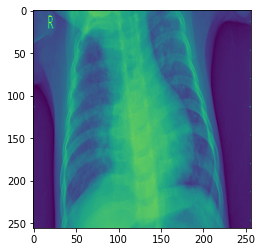

In [17]:
import pathlib
import pandas as pd
import csv
#descargar denuevo el predicted porsiacaso
!gdown --id 10no_phQynbbbWYKmmxKd-Ll0ScQfRvaF

#guardar las predicciones realizadas al CSV predictions
#https://stackoverflow.com/questions/58960358/generate-a-filename-in-python
#https://stackoverflow.com/questions/62654715/how-to-read-images-dataset-in-google-colab-for-deep-learning
test_images = []
predictedCSV = pd.read_csv('predicted.csv', index_col=0)
print(predictedCSV.head())

for i in range(1304):
  imagenTest = io.imread("test_images/" + str(i).zfill(4) + ".png")
  test_images.append(imagenTest)

print(len(test_images))
plt.imshow(test_images[1])
#pasar a 0-1

test_images =  np.asarray(test_images)
test_images = test_images.astype("float32") / 255
test_images = np.expand_dims(test_images, -1)

test_images = simpleCNN.predict(test_images, steps=len(test_images))

test_predicted = []

for i in range(len(test_images)):
  if (test_images[i] >= 0.5):
    #print(1)
    test_predicted.append(1)
  else:
    #print(0)
    test_predicted.append(0)

"""
print("Predicciones: ")
for i in range(24):
  print(test_predicted[i])
"""
predictedCSV["Predicted"] = test_predicted
predictedCSV.to_csv("predicted_rodolfo.csv")
#Rodrigo Estay me ayudo con estas 2 lineas de codigo 

#df = pd.DataFrame(test_predicted, columns=['Predicted'])
#df.to_csv('predicted.csv', mode='w')

print(predictedCSV.head())